<a href="https://colab.research.google.com/github/leonardoub/SCRIPT_PALERMO/blob/master/Callbacks_Network_classification_histology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

#Load data

In [0]:
#load data from Drive
from google.colab import drive
drive.mount('/gdrive')
#%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
train_dataset_path = '/gdrive/My Drive/AIM_PA/database_training2.csv'
test_dataset_path = '/gdrive/My Drive/AIM_PA/database_nostro_without_nan.csv'

In [0]:
df_train = pd.read_csv(train_dataset_path)
df_test = pd.read_csv(test_dataset_path)

In [0]:
df_train.rename(columns={'Survival.time (months)':'Surv_time_months'}, inplace=True)

In [0]:
df_test.rename(columns={'Survival.time (months)':'Surv_time_months'}, inplace=True)

In [0]:
df_train.rename(columns={'Overall.Stage':'Overall_Stage'}, inplace=True)
df_test.rename(columns={'Overall.Stage':'Overall_Stage'}, inplace=True)

In [0]:
train_data = df_train.drop(['Histology', 'Surv_time_months', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

In [0]:
test_data = df_test.drop(['Histology', 'Surv_time_months', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

In [0]:
train_labels = df_train.Histology

In [0]:
test_labels = df_test.Histology

##Z score dei dati

In [0]:
mean = train_data.mean(axis=0)
train_data_stand = train_data - mean
std = train_data.std(axis=0)
train_data_stand /= std

In [0]:
test_data_stand = test_data - mean
test_data_stand /= std

##Vettorizzare i label

In [0]:
word_index={'adenocarcinoma':0, 'large cell':1, 'squamous cell carcinoma':2}

In [0]:
train_labels_dec = [word_index[label] for label in train_labels]

In [0]:
test_labels_dec = [word_index[label] for label in test_labels]

In [0]:
from keras.utils.np_utils import to_categorical

In [0]:
one_hot_train_labels = to_categorical(train_labels_dec)
one_hot_test_labels = to_categorical(test_labels_dec)

#PCA

In [0]:
from sklearn.decomposition import PCA

In [0]:
pca = PCA(n_components=0.9, svd_solver='full')

In [0]:
pca.fit(train_data_stand)

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
    svd_solver='full', tol=0.0, whiten=False)

In [0]:
train_data_stand_pca = pca.transform(train_data_stand)
test_data_stand_pca = pca.transform(test_data_stand)

In [0]:
train_data_stand_pca.shape

(131, 9)

#Building Network

#Stratified k-fold

This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

In [0]:
from sklearn.model_selection import StratifiedKFold

In [0]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
skf.get_n_splits(train_data_stand_pca, train_labels_dec)

3

In [0]:
for train_index, test_index in skf.split(train_data_stand_pca, train_labels_dec):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [  0   1   4   5   8   9  11  12  14  15  16  17  19  20  22  23  24  25
  27  29  30  33  34  36  37  38  39  40  41  42  44  45  46  48  51  52
  53  56  57  58  59  60  62  63  65  66  67  69  72  76  77  78  79  80
  81  83  84  85  87  88  89  90  92  96  97  98 100 101 102 103 104 105
 107 109 110 111 113 115 117 120 121 122 124 125 127 128] TEST: [  2   3   6   7  10  13  18  21  26  28  31  32  35  43  47  49  50  54
  55  61  64  68  70  71  73  74  75  82  86  91  93  94  95  99 106 108
 112 114 116 118 119 123 126 129 130]
TRAIN: [  2   3   5   6   7   8   9  10  11  12  13  18  20  21  25  26  27  28
  29  30  31  32  34  35  36  38  39  43  44  45  46  47  48  49  50  53
  54  55  57  58  61  63  64  65  66  68  70  71  73  74  75  76  78  82
  84  85  86  87  90  91  92  93  94  95  96  99 100 101 102 105 106 108
 109 111 112 114 115 116 118 119 122 123 124 125 126 127 129 130] TEST: [  0   1   4  14  15  16  17  19  22  23  24  33  37  40  41  42  51  52
  56  59 

In [0]:
train_labels_dec[125]

2

In [0]:
from keras.utils import to_categorical


In [0]:
#for train_index, val_index in skf.split(train_data_stand_pca, train_labels_dec):
 
#  partial_train_data = np.array([train_data_stand_pca[i] for i in train_index])
#  partial_train_targets = np.array([train_labels_dec[i] for i in train_index])

#  val_data = np.array([train_data_stand_pca[i] for i in val_index])
#  val_targets = np.array([train_labels_dec[i] for i in val_index])

#  one_hot_partial_train_targets = to_categorical(partial_train_targets)
#  one_hot_val_targets = to_categorical(val_targets)

#  model = build_model()
#  model.fit(partial_train_data, one_hot_partial_train_targets, epochs = num_epochs, batch_size=1)

#  val_loss, val_accuracy = model.evaluate(val_data, one_hot_val_targets)
#  all_scores.append(val_accuracy)
#I parametri per la valutazione vengono calcolati una volta per ogni k-fold, per ogni set di validazione, quindi k volte

C'è un problema: keras.utils.to_categorical produces a one-hot encoded class vector, i.e. the multilabel-indicator mentioned in the error message. StratifiedKFold is not designed to work with such input; i.e. your y must be a 1-D array of your class labels.
Essentially, what you have to do is simply to invert the order of the operations: split first (using your intial y_train), and convert to_categorical afterwards.

In [0]:
num_epochs = 30
all_acc_histories = []
all_loss_histories = []
all_val_acc_histories = []
all_val_loss_histories = []

for train_index, val_index in skf.split(train_data_stand_pca, train_labels_dec):
 
  partial_train_data = np.array([train_data_stand_pca[i] for i in train_index])
  partial_train_targets = np.array([train_labels_dec[i] for i in train_index])
  
  val_data = np.array([train_data_stand_pca[i] for i in val_index])
  val_targets = np.array([train_labels_dec[i] for i in val_index])

  one_hot_partial_train_targets = to_categorical(partial_train_targets)
  one_hot_val_targets = to_categorical(val_targets)

  model = build_model()
  history = model.fit(partial_train_data, one_hot_partial_train_targets, validation_data=(val_data, one_hot_val_targets), 
                      epochs=num_epochs, batch_size=10)
  
  acc_history = history.history['accuracy']
  all_acc_histories.append(acc_history)

  loss_history = history.history['loss']
  all_loss_histories.append(loss_history)

  acc_val_history = history.history['val_accuracy']
  all_val_acc_histories.append(acc_val_history)

  loss_val_history = history.history['val_loss']
  all_val_loss_histories.append(loss_val_history)
  

#I parametri per la valutazione vengono calcolati per ogni epoca, quindi num_epochs volte. 
#Il tutto viene ripetuto un numero di volte pari a n_splits.
#Si ottiene una lista con n_splits elementi ciascuno dei quali è una lista lunga num_epochs,
#ogni elemento può essere uno fra questi: dict_keys(['val_loss', 'val_acc', 'loss', 'acc']) 

Train on 86 samples, validate on 45 samples
Epoch 1/30
86/86 [==============================] - 0s 4ms/sample - loss: 1.7603 - accuracy: 0.3837 - val_loss: 1.4380 - val_accuracy: 0.3333
Epoch 2/30
86/86 [==============================] - 0s 308us/sample - loss: 1.6349 - accuracy: 0.3605 - val_loss: 1.3908 - val_accuracy: 0.3333
Epoch 3/30
86/86 [==============================] - 0s 319us/sample - loss: 1.5324 - accuracy: 0.3953 - val_loss: 1.3512 - val_accuracy: 0.3556
Epoch 4/30
86/86 [==============================] - 0s 281us/sample - loss: 1.4462 - accuracy: 0.3953 - val_loss: 1.3195 - val_accuracy: 0.3556
Epoch 5/30
86/86 [==============================] - 0s 292us/sample - loss: 1.3780 - accuracy: 0.3953 - val_loss: 1.2938 - val_accuracy: 0.4000
Epoch 6/30
86/86 [==============================] - 0s 330us/sample - loss: 1.3197 - accuracy: 0.4070 - val_loss: 1.2728 - val_accuracy: 0.4222
Epoch 7/30
86/86 [==============================] - 0s 297us/sample - loss: 1.2695 - accuracy:

In [0]:
history_dict = history.history

In [0]:
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [0]:
len(all_acc_histories[2])

30

In [0]:
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
#media per epoca degli score ottenuti per tutte le k-fold
#per ogni k-fold di fanno num_epoch epoche, la media viene fatta prendendo gli score di tutti i k-fold relativi ad una data epoca,
#e si fa questo per tutte le epoche
average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]


In [0]:
len(average_val_acc_history)

30

##Plotting training and validation loss

In [0]:
import matplotlib.pyplot as plt

In [0]:
epochs = range(1, num_epochs+1)

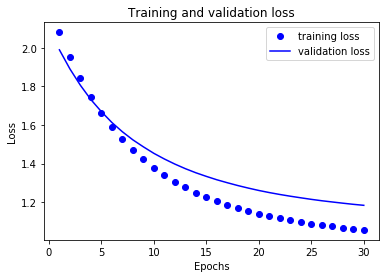

In [0]:
plt.plot(epochs, average_loss_history, 'bo', label='training loss')
plt.plot(epochs, average_val_loss_history, 'b', label='validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

##Plotting train and validation accuracy

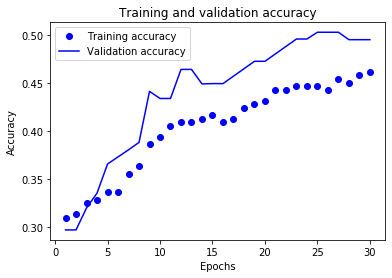

In [0]:
plt.plot(epochs, average_acc_history, 'bo', label='Training accuracy')
plt.plot(epochs, average_val_acc_history, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend() 

In [0]:
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence

In [0]:
from tensorflow.keras import layers

In [0]:
from tensorflow.keras import regularizers

In [0]:
from tensorflow.keras.optimizers import SGD

In [0]:
def build_model():
  model = keras.models.Sequential()
  model.add(layers.Dense(6, activation='relu', input_shape=(9,)))
  model.add(layers.Dense(3, activation='softmax'))
  sgd = SGD(lr=0.001, decay=1e-6, momentum=0.5, nesterov=True)
  model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
  return model